# Model strengthening - Problem Segmentation

In [1]:
# import 
import os
import re

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import networkx as nx

import random

Since we have a couple of "forest stand patches" that are separated from each other by areas that are already accessible, we can split the original problem into smaller problems, corresponding to the segmentation of the study area

1. Create a Graph Representation: Treat each stand as a node and create edges between nodes that are touching (intersecting geometrically).

2. Find Connected Components: Use a graph library (like NetworkX) to find all connected components.

#### Step 1 Create a graph for stands unaccessible by roads

##### Roads

In [57]:
# Create a graph for stands unaccessible by roads
G = nx.Graph()

# Add nodes (you can use the index or a specific ID)
for idx, row in not_touching_roads.iterrows():
    G.add_node(row['ID_UG'])  # Replace 'ID' with your actual ID column name

# Add edges for touching geometries
for i, geom1 in enumerate(not_touching_roads.geometry):
    for j, geom2 in enumerate(not_touching_roads.geometry):
        if i != j and geom1.intersects(geom2):  # Check if geometries are touching
            G.add_edge(not_touching_roads.iloc[i]['ID_UG'], not_touching_roads.iloc[j]['ID_UG'])  # Replace 'ID' with your actual ID column name


##### BIG roads

In [58]:
# Create a graph for stands unaccessible by bigroads
GBig = nx.Graph()

# Add nodes (you can use the index or a specific ID)
for idx, row in not_touching_bigroads.iterrows():
    GBig.add_node(row['ID_UG'])  # Replace 'ID' with your actual ID column name

# Add edges for touching geometries
for i, geom1 in enumerate(not_touching_bigroads.geometry):
    for j, geom2 in enumerate(not_touching_bigroads.geometry):
        if i != j and geom1.intersects(geom2):  # Check if geometries are touching
            GBig.add_edge(not_touching_bigroads.iloc[i]['ID_UG'], not_touching_bigroads.iloc[j]['ID_UG'])  # Replace 'ID' with your actual ID column name


#### Step 2 Find connected components

In [59]:
# find connected components
connected_components = list(nx.connected_components(G))

print('Connected components:', len(connected_components))

Connected components: 67


In [60]:
# find connected components bigroads
connected_components_B = list(nx.connected_components(GBig))

print('Connected components:', len(connected_components_B))

Connected components: 54


#### Step 3 Separate isolated stands from bigger connected components
The single component stand each require to be connected to the network separately. This decision can be taken separately.

In [61]:
# separate isolated stands from nonsingle connected components
single_stand_components = [component for component in connected_components if len(component) == 1]
print('Isolated stands:',len(single_stand_components))

# filter for nonsingle components
nonsingle_components = [component for component in connected_components if len(component) > 1]
print('Non-single components:', len(nonsingle_components))

Isolated stands: 46
Non-single components: 21


In [62]:
# separate isolated stands from bigger connected components bigroads
single_stand_components_B = [component for component in connected_components_B if len(component) == 1]
print('Bigroads isolated stands:',len(single_stand_components_B))
# filter for bigger components
nonsingle_components_B = [component for component in connected_components_B if len(component) > 1]
print('Bigroads non-single components:', len(nonsingle_components_B))

Bigroads isolated stands: 28
Bigroads non-single components: 26


#### Visualize

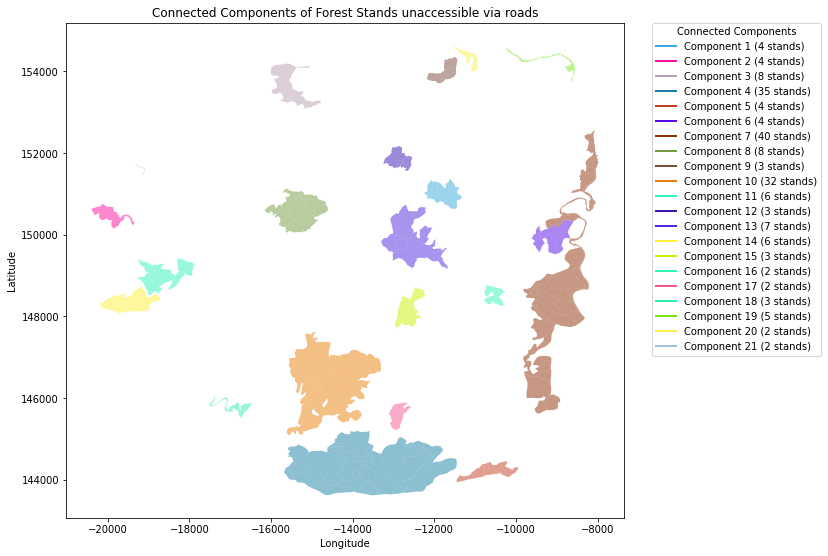

In [63]:
# Plot the patches

# Create a color map
colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(len(nonsingle_components))]

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

legend_handles=[]

# Loop through each connected component and plot
for i, component in enumerate(nonsingle_components):
    # Filter the GeoDataFrame for the current component
    component_gdf = not_touching_roads[not_touching_roads['ID_UG'].isin(component)]  # Replace 'ID' with your actual ID column

    # Choose a color (cycling through the list of colors)
    color = colors[i % len(colors)]

    # Plot the component
    component_gdf.plot(ax=ax, color=color, alpha=0.5)

    # Create a custom legend handle
    legend_handles.append(Line2D([0], [0], color=color, lw=2, label=f'Component {i + 1} ({len(component)} stands)'))

# Create a custom legend outside the plot
ax.legend(handles=legend_handles, title="Connected Components", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Set titles and labels if necessary
ax.set_title('Connected Components of Forest Stands unaccessible via roads')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


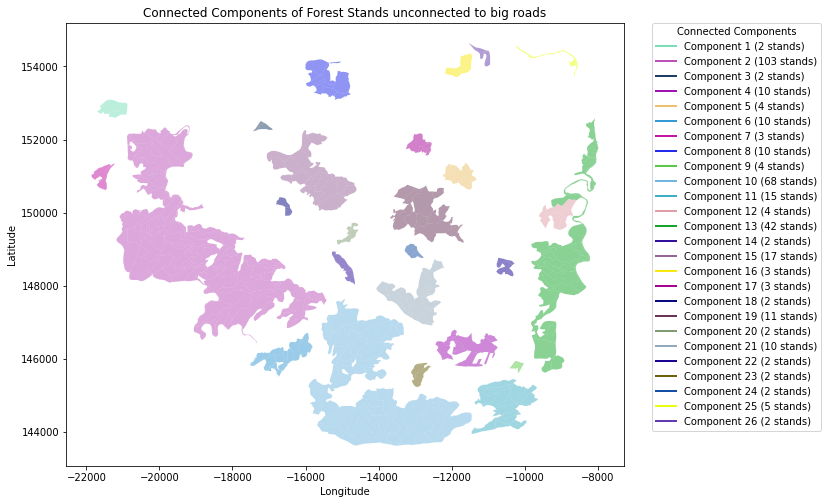

In [64]:
# Plot the patches bigroads

# Create a color map
colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(len(nonsingle_components_B))]

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

legend_handles=[]

# Loop through each connected component and plot
for i, component in enumerate(nonsingle_components_B):
    # Filter the GeoDataFrame for the current component
    component_gdf = not_touching_bigroads[not_touching_bigroads['ID_UG'].isin(component)]  # Replace 'ID' with your actual ID column

    # Choose a color (cycling through the list of colors)
    color = colors[i % len(colors)]

    # Plot the component
    component_gdf.plot(ax=ax, color=color, alpha=0.5)

    # Create a custom legend handle
    legend_handles.append(Line2D([0], [0], color=color, lw=2, label=f'Component {i + 1} ({len(component)} stands)'))

# Create a custom legend outside the plot
ax.legend(handles=legend_handles, title="Connected Components", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Set titles and labels if necessary
ax.set_title('Connected Components of Forest Stands unconnected to big roads')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


#### Step 4 Save separate dfs for each component

In [ ]:
# List to store the resulting GeoDataFrames
nonsingle_components_gdfs = []

for i, component in enumerate(nonsingle_components):
    # Filter the original GeoDataFrame for rows where 'ID_UG' is in the current component
    component_gdf = not_touching_roads[not_touching_roads['ID_UG'].isin(component)]
    
    # Append the resulting GeoDataFrame to the list (you can also save it with a specific name or handle)
    nonsingle_components_gdfs.append(component_gdf)
    
    # Optionally, print the size of each component GeoDataFrame
    print(f"Component {i+1}: {len(component_gdf)} stands")

    # Create folder if it doesn't exist
    component_folder = f"1_Preprocessed_Data/Stand_Components/unconnected_to_roads/comp_{i+1}"
    if not os.path.exists(component_folder):
        os.makedirs(component_folder)

    # Save to shapefile
    shapefile_path = os.path.join(component_folder, f"component_{i+1}.shp")
    component_gdf.to_file(shapefile_path)
    print(f'Saved component_{i+1} as shapefile')


Component 1: 4 stands
Saved component_1 as shapefile
Component 2: 4 stands
Saved component_2 as shapefile
Component 3: 8 stands
Saved component_3 as shapefile
Component 4: 35 stands
Saved component_4 as shapefile
Component 5: 4 stands
Saved component_5 as shapefile
Component 6: 4 stands
Saved component_6 as shapefile
Component 7: 40 stands
Saved component_7 as shapefile
Component 8: 8 stands
Saved component_8 as shapefile
Component 9: 3 stands
Saved component_9 as shapefile
Component 10: 32 stands
Saved component_10 as shapefile
Component 11: 6 stands
Saved component_11 as shapefile
Component 12: 3 stands
Saved component_12 as shapefile
Component 13: 7 stands
Saved component_13 as shapefile
Component 14: 6 stands
Saved component_14 as shapefile
Component 15: 3 stands
Saved component_15 as shapefile
Component 16: 2 stands
Saved component_16 as shapefile
Component 17: 2 stands
Saved component_17 as shapefile
Component 18: 3 stands
Saved component_18 as shapefile
Component 19: 5 stands
Sa

In [66]:
# bigroads # List to store the resulting GeoDataFrames
B_nonsingle_components_gdfs = []

for i, component in enumerate(nonsingle_components_B):
    # Filter the original GeoDataFrame for rows where 'ID_UG' is in the current component
    component_gdf = not_touching_bigroads[not_touching_bigroads['ID_UG'].isin(component)]
    
    # Append the resulting GeoDataFrame to the list (you can also save it with a specific name or handle)
    B_nonsingle_components_gdfs.append(component_gdf)
    
    # Optionally, print the size of each component GeoDataFrame
    print(f"Component {i+1}: {len(component_gdf)} stands")

    # Create folder if it doesn't exist
    component_folder = f"1_Preprocessed_Data/Stand_Components/unconnected_to_bigroads/comp_{i+1}"
    if not os.path.exists(component_folder):
        os.makedirs(component_folder)

    # Save to shapefile
    shapefile_path = os.path.join(component_folder, f"component_{i+1}.shp")
    component_gdf.to_file(shapefile_path)
    print(f'Saved component_{i+1} as shapefile')


Component 1: 2 stands
Saved component_1 as shapefile
Component 2: 103 stands
Saved component_2 as shapefile
Component 3: 2 stands
Saved component_3 as shapefile
Component 4: 10 stands
Saved component_4 as shapefile
Component 5: 4 stands
Saved component_5 as shapefile
Component 6: 10 stands
Saved component_6 as shapefile
Component 7: 3 stands
Saved component_7 as shapefile
Component 8: 10 stands
Saved component_8 as shapefile
Component 9: 4 stands
Saved component_9 as shapefile
Component 10: 68 stands
Saved component_10 as shapefile
Component 11: 15 stands
Saved component_11 as shapefile
Component 12: 4 stands
Saved component_12 as shapefile
Component 13: 42 stands
Saved component_13 as shapefile
Component 14: 2 stands
Saved component_14 as shapefile
Component 15: 17 stands
Saved component_15 as shapefile
Component 16: 3 stands
Saved component_16 as shapefile
Component 17: 3 stands
Saved component_17 as shapefile
Component 18: 2 stands
Saved component_18 as shapefile
Component 19: 11 st

In [ ]:
# Iterate over components and save separate DataFrames
nonsingle_components_dfs = []

for i, component in enumerate(nonsingle_components):
    # Filter the original DataFrame for rows where 'ID_UG' is in the current component
    component_df = not_touching_roads[not_touching_roads['ID_UG'].isin(component)]
    
    # Append the resulting DataFrame to the list (you can also save it with a specific name or handle)
    nonsingle_components_dfs.append(component_df)
    
    # Optionally, print the size of each component DataFrame
    print(f"Component {i+1}: {len(component_df)} stands")

    # create folder
    if not os.path.exists(f"1_Preprocessed_Data/Stand_Components/unconnected_to_roads/comp_{i+1}"):
        os.makedirs(f"1_Preprocessed_Data/Stand_Components/unconnected_to_roads/comp_{i+1}")

    # save to file
    component_df.to_csv(f"1_Preprocessed_Data/Stand_Components/unconnected_to_roads/comp_{i+1}/component_{i+1}.csv", index=False)
    print('saved')
# At this point, `bigger_components_dfs` contains a list of DataFrames for each larger connected component


Component 1: 4 stands
saved
Component 2: 4 stands
saved
Component 3: 8 stands
saved
Component 4: 35 stands
saved
Component 5: 4 stands
saved
Component 6: 4 stands
saved
Component 7: 40 stands
saved
Component 8: 8 stands
saved
Component 9: 3 stands
saved
Component 10: 32 stands
saved
Component 11: 6 stands
saved
Component 12: 3 stands
saved
Component 13: 7 stands
saved
Component 14: 6 stands
saved
Component 15: 3 stands
saved
Component 16: 2 stands
saved
Component 17: 2 stands
saved
Component 18: 3 stands
saved
Component 19: 5 stands
saved
Component 20: 2 stands
saved
Component 21: 2 stands
saved


In [ ]:
# Iterate over bigger components and create separate DataFrames
nonsingle_components_B_dfs = []

for i, component in enumerate(nonsingle_components_B):
    # Filter the original DataFrame for rows where 'ID_UG' is in the current component
    component_df = not_touching_bigroads[not_touching_bigroads['ID_UG'].isin(component)]
    
    # Append the resulting DataFrame to the list (you can also save it with a specific name or handle)
    nonsingle_components_B_dfs.append(component_df)
    
    # Optionally, print the size of each component DataFrame
    print(f"Component {i+1}: {len(component_df)} stands")

    # create folder
    if not os.path.exists(f"1_Preprocessed_Data/Stand_Components/unconnected_to_bigroads/comp_{i+1}"):
        os.makedirs(f"1_Preprocessed_Data/Stand_Components/unconnected_to_bigroads/comp_{i+1}")

    # save to file
    component_df.to_csv(f"1_Preprocessed_Data/Stand_Components/unconnected_to_bigroads/comp_{i+1}/component_{i+1}.csv", index=False)
    print('saved')

# At this point, `bigger_components_dfs` contains a list of DataFrames for each larger connected component

Component 1: 2 stands
saved
Component 2: 103 stands
saved
Component 3: 2 stands
saved
Component 4: 10 stands
saved
Component 5: 4 stands
saved
Component 6: 10 stands
saved
Component 7: 3 stands
saved
Component 8: 10 stands
saved
Component 9: 4 stands
saved
Component 10: 68 stands
saved
Component 11: 15 stands
saved
Component 12: 4 stands
saved
Component 13: 42 stands
saved
Component 14: 2 stands
saved
Component 15: 17 stands
saved
Component 16: 3 stands
saved
Component 17: 3 stands
saved
Component 18: 2 stands
saved
Component 19: 11 stands
saved
Component 20: 2 stands
saved
Component 21: 10 stands
saved
Component 22: 2 stands
saved
Component 23: 2 stands
saved
Component 24: 2 stands
saved
Component 25: 5 stands
saved
Component 26: 2 stands
saved
